# Predicting Database Capacity

### Summary

When managing a small amount of databases, a simple database growth chart is an effective tool for capacity planning.  However, as an environment grows into the 100s or 1000s of databases, performing chart based capacity planning can be very tedious.

Machine learning is an effective tool for automatically calculating growth trends and predicting database growth.

### Data Preparation

Import common libraries.

In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

Here we will import a CSV file of database size readings.  This CSV is an extract from an enterprise monitoring tool and is used for this demonstration only.  In production, you should consider connecting to your enterprise monitoring tool directly.

In [2]:
data = pd.read_csv('data/DiskReads.csv')
data.head()

,ReadDate,GBUsed
0,4/10/2019,9193
1,4/9/2019,9184
2,4/8/2019,9183
3,4/7/2019,9183
4,4/6/2019,9184


Dates can prove problematic for machine learning. An effective approach in this example is to convert a date to an integer value where:

- Zero is today
- A negative integer corresponds to the number of days in the past
- A positive integer corresponds to the number of days in the future

Using the datetime libary, we can calculate these integer values.

In [12]:
from datetime import date, datetime, timedelta
# Calculate the delta
data['DaysBack'] = (pd.to_datetime(data['ReadDate']) - datetime.today()).dt.days

data.head()

,ReadDate,GBUsed,DaysBack
0,4/10/2019,9193,-3
1,4/9/2019,9184,-4
2,4/8/2019,9183,-5
3,4/7/2019,9183,-6
4,4/6/2019,9184,-7


### Model Fit and Scoring

With the data in an appropriate format, we can fit and score our model.

In [13]:
# Assign the appropriate columns
X = data['DaysBack'].values.reshape(-1,1)
y = data['GBUsed'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit a linear regression model
lm = linear_model.LinearRegression()  
lm.fit(X_train, y_train)

# Score the model on the test data
lm.score(X_test,y_test)

0.9934231470880599

A linear regression scores very well on this example.  Graphing our data and the model we can see that this database has very consistent an predictable growth.

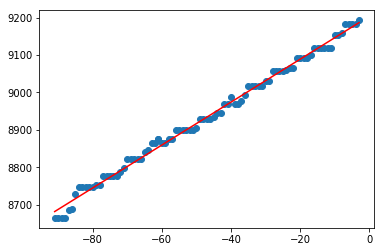

In [14]:
plt.plot(X, y, 'o')
plt.plot(X, lm.coef_ * X + lm.intercept_, '-', color='red', label='Trend')
plt.show()

A prediction can be made about when the database will completely fill the drive on the server.  The drive in question is 10TB.

Utilizing the equation for a line, instead of solving for y we will solve for x, where:
- **x** corresponds to the day we will hit capacity based on current growth rate
- **y** corresponds to drive capacity in GB
- **m** is the slope of our regression line, provided by the model via *lm.coef_*
- **b** is the intercept of the regression line, also provided by the model via *lm.intercept_*

In [15]:
# The database drive is 10TB
drive_capacity = 10000

# Instead of solving for y, solve for x
# y = mx + b
# x = (y - b) / m
days_until_capacity = (drive_capacity - lm.intercept_) / lm.coef_

# days_until_capacity is the number of days until we hit drive capacity
print ("Days Until Capacity:", days_until_capacity)

# Perform a time delta to determine the calendar date
capacity_date = date.today() + timedelta(days=days_until_capacity[0])
print ("Reach Capacity On: ", capacity_date)


Days Until Capacity: [138.86209144]
Reach Capacity On:  2019-08-28


We will reach drive capacity in 138 days, which corresponds to August 28th, 2019.  We can now plot the data, model, and the predicted day we will reach capacity.

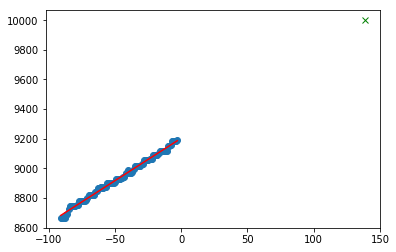

In [16]:
plt.plot(X,y, 'o')
plt.plot(X, lm.coef_ * X + lm.intercept_, '-', color='red', label='Trend')
plt.plot(days_until_capacity, drive_capacity, 'x', color='green')
plt.show()

### Conclusion

Using machine learning we can automatically trend database growth and calculate future resource needs.  Using machine learning has several advantages over manually viewing growth charts including scalability, efficiency, and consistency.

While this is not a sophisticated use of machine learning, it is an effective method of capacity planning database infrastructure at scale.

Next steps:

- Remove the CSV file from the pipeline and connect directly to an enterprise metrics database
- Loop through an inventory of servers (and drives) and fit a model to each drive
- Filter the output of this application, showing only high scoring models with upcoming capacity concerns